# Práctica TinyML con Tensorflow Lite (micro) y CIFAR-10 

Se utiliza un modelo de clasificación de imágenes basado en la estructura de MobileNet v1 utilizando el dataset de Cifar-10 para emular en un 'Arm Cortex-M3' (con el emulador QEMU con OS Zephyr)

In [1]:
%tensorflow_version 2.x

### Librerías Python


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Model
from tensorflow.keras import datasets, layers, models

### Constantes

In [3]:
TF_MODEL="cifar10"
TFL_MODEL_FILE="cifar10.tflite"

## Diseño y entrenamiento del modelo tiny CIFAR-10

### Descarga del dataset CIFAR-10

In [4]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


### Normalización de valores de pixel entre 0 y 1

In [5]:
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

### Visualización de algunas imágenes

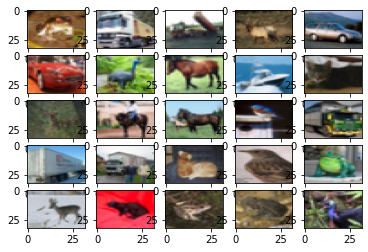

In [6]:
fig, ax = plt.subplots(5, 5)
k = 0
 
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(train_imgs[k], aspect='auto')
        k += 1
 
plt.show()

### Definir una función en Python que implemente DWSC

In [7]:
def separable_conv(input, ch, idx):
    x = layers.DepthwiseConv2D((3,3), padding="same", name='dwc0_dwsc'+str(idx))(input)
    x = layers.BatchNormalization( name='bn0_dwsc'+str(idx))(x)
    x = layers.Activation("relu", name='act0_dwsc'+str(idx))(x)
    x = layers.Conv2D(ch, (1,1), padding="same", name='conv0_dwsc'+str(idx))(x)
    x = layers.BatchNormalization(name='bn1_dwsc'+str(idx))(x)
    return layers.Activation("relu", name='act1_dwsc'+str(idx))(x)

### Diseño de la convolución base

In [8]:
input = layers.Input((32,32,3))

x = layers.Conv2D(16, (3, 3), padding='same', name='conv1')(input)
x = layers.BatchNormalization(name='bn1')(x)
x = layers.Activation("relu", name='act1')(x)
x = separable_conv(x, 24, 2)
x = layers.MaxPooling2D((2, 2), name='pool1')(x)
x = separable_conv(x, 48, 3)
x = layers.MaxPooling2D((2, 2), name='pool2')(x)
x = separable_conv(x, 96, 4)
x = separable_conv(x, 192, 5)
x = layers.MaxPooling2D((2, 2), name='pool3')(x)

### Diseño del clasificador

In [9]:
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10)(x)

### Generar el modelo y ver estructura

In [10]:
model = Model(input, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 bn1 (BatchNormalization)    (None, 32, 32, 16)        64        
                                                                 
 act1 (Activation)           (None, 32, 32, 16)        0         
                                                                 
 dwc0_dwsc2 (DepthwiseConv2D  (None, 32, 32, 16)       160       
 )                                                               
                                                                 
 bn0_dwsc2 (BatchNormalizati  (None, 32, 32, 16)       64        
 on)                                                         

### Evaluar los tensores medios
*Esta paso no es necesario, pero lo hacemos para ver donde podríamos encontrar problemas para implementar nuestro modelo con respectos a los requerimientos hardware.*

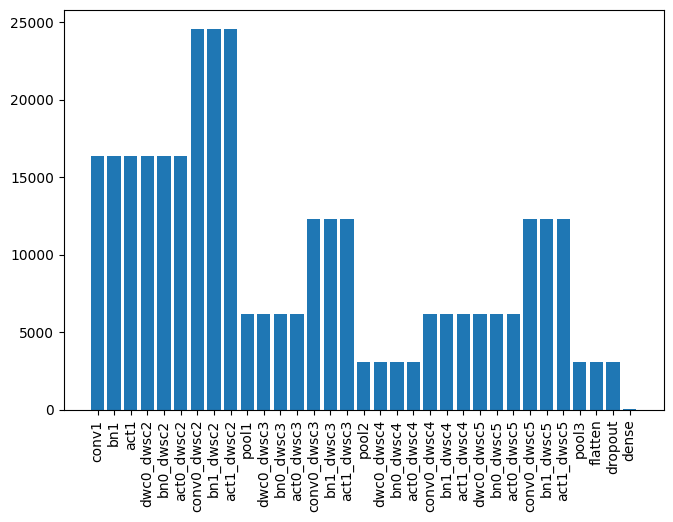

In [11]:
fig = plt.figure(dpi=100)

ax = fig.add_axes([0,0,1,1])

l_idx   = []
l_sizes = []

for layer in model.layers[1:]:
  shape = layer.output_shape
  shape = np.delete(shape, 0)
  size  = np.prod(shape)
  l_idx   = np.append(l_idx, layer.name)
  l_sizes = np.append(l_sizes, size)

ax.bar(l_idx, l_sizes)
plt.xticks(rotation='vertical')
plt.show()

### Compilar y entrenar el modelo con 100 epochs

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_imgs, train_lbls, epochs=100, 
                    validation_data=(test_imgs, test_lbls))

Epoch 1/100
1563/1563 [==============================] - 29s 17ms/step - loss: 1.5765 - accuracy: 0.4698 - val_loss: 1.3103 - val_accuracy: 0.5398
Epoch 2/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1066 - accuracy: 0.6112 - val_loss: 1.0498 - val_accuracy: 0.6276
Epoch 3/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9386 - accuracy: 0.6695 - val_loss: 1.0034 - val_accuracy: 0.6467
Epoch 4/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8290 - accuracy: 0.7088 - val_loss: 0.9198 - val_accuracy: 0.6756
Epoch 5/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7609 - accuracy: 0.7336 - val_loss: 0.8467 - val_accuracy: 0.7026
Epoch 6/100
1563/1563 [==============================] - 24s 15ms/step - loss: 0.7022 - accuracy: 0.7552 - val_loss: 0.9016 - val_accuracy: 0.6970
Epoch 7/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.6529 - accuracy: 0.7716 - val_loss: 0

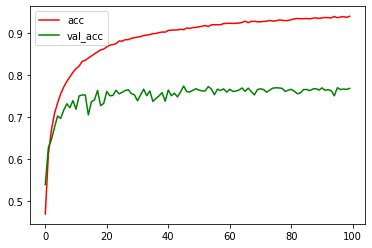

In [14]:
# Accuracy obtenida por epocas

plt.plot(history.history['accuracy'], label='acc', color='red')
plt.plot(history.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

Etiqueta original es ship y etiqueta predicción ship


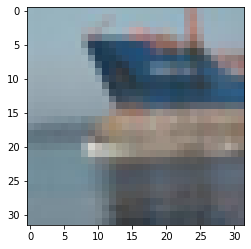

In [39]:
# etiquetas
labels = '''airplane automobile bird cat deer dog frog horse ship truck'''.split()
 
# seleccionar una imagen
image_number = 126

 
# mostrar imagen
plt.imshow(test_imgs[image_number])

n = np.array(test_imgs[image_number])
 
p = n.reshape(1, 32, 32, 3)
 
# predicción
predicted_label = labels[model.predict(p).argmax()]
 
# etiqueta original
original_label = test_lbls[image_number]
original_label = labels[original_label[0]]
# mostrar resultado
print("Etiqueta original es {} y etiqueta predicción {}".format(
    original_label, predicted_label))



### Salvar modelo TensorFlow

In [18]:
model.save(TF_MODEL)

INFO:tensorflow:Assets written to: cifar10/assets


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Evaluando la 'accuracy' del modelo TFLite

### Seleccionamos un grupo de pruebas para hacar la quantificación

In [20]:
cifar_ds = tf.data.Dataset.from_tensor_slices(train_imgs).batch(1)
def representative_data_gen():
  for i_value in cifar_ds.take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

### Inicializa el convertidof TFLite para 8-bit 

In [21]:
tfl_conv = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
tfl_conv.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
tfl_conv.optimizations = [tf.lite.Optimize.DEFAULT]
tfl_conv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tfl_conv.inference_input_type = tf.int8
tfl_conv.inference_output_type = tf.int8

### Convierte el modelo a formato TFLite y lo salva como .tflite

In [22]:
tfl_model = tfl_conv.convert()
open(TFL_MODEL_FILE, "wb").write(tfl_model)

81304

### Calculamos el tamaño del modelo

In [23]:
print(len(tfl_model))

81304


### Evaluamos el 'accuracy' del modelo cuantificado usando el dataset de test

In [24]:
# Inicializamos el interprede de TFLite
tfl_inter = tf.lite.Interpreter(model_content=tfl_model)

# Se asignan los tensores
tfl_inter.allocate_tensors()

# Obtenemos la input/output de la capa
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

i_quant = i_details["quantization_parameters"]
o_quant = o_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]
o_scale      = o_quant['scales'][0]
o_zero_point = o_quant['zero_points'][0]

def classify(i_data, o_value):
  input_data = i_value.reshape((1, 32, 32, 3))
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  
   # Cuantifica (float -> 8-bit) de entrada
  i_value_f32 = i_value_f32 / i_scale + i_zero_point
  i_value_s8 = tf.cast(i_value_f32, dtype=tf.int8)

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  return (o_pred - o_zero_point) * o_scale

num_correct_samples = 0
num_total_samples   = len(list(test_imgs))

for i_value, o_value in zip(test_imgs, test_lbls):
  o_pred_f32 = classify(i_value, o_value)
  if np.argmax(o_pred_f32) == o_value:
    num_correct_samples += 1

In [25]:
print("Accuracy:", num_correct_samples/num_total_samples)

Accuracy: 0.7218


### Convertir el modelo TFLite a C-byte array con xxd

In [26]:
!apt-get update && apt-get -qq install xxd
!xxd -i cifar10.tflite > model.h

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa

## Convertir una imagen NumPy a C-byte array

### Función que convierte un 1D NumPy array de valores np.int8 values a 
caracteres de valores enteros separados por coma.

In [27]:
def array_to_str(data):
    NUM_COLS = 12
    val_string = ''
    for i, val in enumerate(data):
        val_string += str(val)

        if (i + 1) < len(data):
            val_string += ','
        if (i + 1) % NUM_COLS == 0:
            val_string += '\n'
    return val_string

### Función para generar el fichero de cabecera en C que contiene la imagen de entrada para la prueba en formato int8_t array.

In [28]:
def gen_h_file(size, data, ilabel):
  str_out = f'int8_t g_test[] = '
  str_out += "\n{\n"
  str_out += f'{data}'
  str_out += '};\n'
  str_out += f"const int g_test_len = {size};\n"
  str_out += f"const int g_test_ilabel = {ilabel};\n"
  return str_out

### Create a Pandas data frame from the CIFAR-10 test dataset

In [29]:
imgs = list(zip(test_imgs, test_lbls))
cols = ['Image', 'Label']
df = pd.DataFrame(imgs, columns = cols) 

### Obtenemos solo imágnes de barcos.

In [30]:
cond = df['Label'] == 8
ship_samples = df[cond]

### Itera sobre las imágenes obtenidas y devuelve una clasificada como barco.

In [31]:
c_code = ""

for index, row in ship_samples.iterrows():
  i_value = np.asarray(row['Image'].tolist())
  o_value = np.asarray(row['Label'].tolist())
  o_pred_f32 = classify(i_value, o_value)
  if np.argmax(o_pred_f32) == o_value:
    i_value_f32 = i_value / i_scale + i_zero_point
    i_value_s8  = i_value_f32.astype(dtype=np.uint8)
    i_value_s8  = i_value_s8.ravel()

    # Generate a string from NumPy array
    val_string = array_to_str(i_value_s8)
    c_code = gen_h_file(i_value_s8.size, val_string, "8")
    break


### Se salva la imagen generada como input.h.

In [43]:
with open("input.h", 'w') as file:
  file.write(c_code)